## **Importing Modules**

In [3]:
# pip uninstall torch torchvision torchaudio


In [4]:
#importing required modules

import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


## **Data Preprocessing**

In [5]:
#importing data

# #Dataset address
# url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
# output = 'data.zip'
# # gdown.download(url, output, quiet=False)

# #giving zip file name
# data_dir='./data.zip'

# #extractng data from zip file
# with zipfile.ZipFile(data_dir, 'r') as zf:
#     zf.extractall('./data')
#     print('Done downloading and extraction')

# #removing zip file after extraction
# !rm './data.zip' 

#invstigating number of files
cactus_files = np.array(glob("./split/*/*/*"))
print('There are %d total  images.' % len(cactus_files))

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

There are 17500 total  images.


In [6]:
use_cuda = torch.cuda.is_available()

In [7]:
use_cuda

True

In [8]:
transform = T.Compose([T.ToTensor(),])
data_file='./split/'

train_path=os.path.join(data_file,'train')
dataset = datasets.ImageFolder(train_path,transform=transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False)

# mean = torch.zeros(3)
# std = torch.zeros(3)

# for i, data in enumerate(dataloader):
#     if (i % 10000 == 0): print(i)
#     data = data[0].squeeze(0)
#     if (i == 0): size = data.size(1) * data.size(2)
#     mean += data.sum((1, 2)) / size

# mean /= len(dataloader)
# print(mean)
# mean = mean.unsqueeze(1).unsqueeze(2)

# for i, data in enumerate(dataloader):
#     if (i % 10000 == 0): print(i)
#     data = data[0].squeeze(0)
#     std += ((data - mean) ** 2).sum((1, 2)) / size

# std /= len(dataloader)
# std = std.sqrt()
# print(std)

In [ ]:
#declaring batch size
batch_size = 128

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(32,32)), 
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477]), 
    ]),
    

    'valid':
    T.Compose([
        T.Resize(size=(32,32)),
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477])
    ]),


    'test':
    T.Compose([
        T.Resize(size=(32,32)),
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477])
    ]),
}



train_path=os.path.join(data_file,'train')
valid_path=os.path.join(data_file,'test')
test_path=os.path.join(data_file,'valid')


# creating datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

## **Model Building**

In [23]:
# model_transfer

In [ ]:
import torch.nn as nn

# Importing the pretrained model
# model_transfer = models.resnet50(pretrained=True)

# Freeze weights
# for param in model_transfer.parameters():
#     param.requires_grad = False

# n_inputs = model_transfer.fc.in_features

#Replacing the top dense layers with self defined trainable layers
model_transfer = nn.Sequential(
 nn.Flatten(),   
            nn.Linear(32 * 32 * 3, 1024),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(256, 64),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(64, 16),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(16, 2),
           
        )

#transferring the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

In [26]:
model_transfer

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01, inplace=True)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01, inplace=True)
  (6): Linear(in_features=256, out_features=64, bias=True)
  (7): LeakyReLU(negative_slope=0.01, inplace=True)
  (8): Linear(in_features=64, out_features=16, bias=True)
  (9): LeakyReLU(negative_slope=0.01, inplace=True)
  (10): Linear(in_features=16, out_features=2, bias=True)
)

In [27]:
summary(model_transfer, (3, 32,32))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x32 and 3072x1024)

In [ ]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Compute class weights
class_counts = np.bincount(train_file.targets)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
if use_cuda:
    class_weights_tensor = class_weights_tensor.cuda()

# Loss with class weights
criterion_transfer = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer for the whole model
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

In [ ]:
class_counts

array([9195, 3055], dtype=int64)

In [ ]:
class_weights

array([0.24938776, 0.75061224])

In [ ]:
# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
if use_cuda:
    class_weights_tensor = class_weights_tensor.cuda()

# Loss with class weights
criterion_transfer = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer for the whole model
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

## **Training and Validating the Model**



In [ ]:
use_cuda

True

In [ ]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)

       
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)

      

        # train_loss = train_loss/len(train_file)
        # valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.4f}'.format(
            epoch,
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [ ]:
# training the model

n_epochs=500

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.443938 	Training Accuracy: 90.5633 	Validation Loss: 0.502541 	Validation Accuracy: 81.1048
Validation loss decreased (inf --> 0.502541).  Saving model ...
Epoch: 2 	Training Loss: 0.481085 	Training Accuracy: 88.4735 	Validation Loss: 0.380469 	Validation Accuracy: 93.1810
Validation loss decreased (0.502541 --> 0.380469).  Saving model ...
Epoch: 3 	Training Loss: 0.432715 	Training Accuracy: 88.5959 	Validation Loss: 0.584639 	Validation Accuracy: 73.3333
Epoch: 4 	Training Loss: 0.399943 	Training Accuracy: 90.0816 	Validation Loss: 0.362620 	Validation Accuracy: 92.6857
Validation loss decreased (0.380469 --> 0.362620).  Saving model ...
Epoch: 5 	Training Loss: 0.347586 	Training Accuracy: 96.4816 	Validation Loss: 0.398572 	Validation Accuracy: 94.2476
Epoch: 6 	Training Loss: 0.362538 	Training Accuracy: 94.2041 	Validation Loss: 0.371617 	Validation Accuracy: 91.3905
Epoch: 7 	Training Loss: 0.351353 	Training Accuracy: 95.6490 	Validation Loss: 0.37

In [ ]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [ ]:
train_loss

[tensor(0.4439, device='cuda:0'),
 tensor(0.4811, device='cuda:0'),
 tensor(0.4327, device='cuda:0'),
 tensor(0.3999, device='cuda:0'),
 tensor(0.3476, device='cuda:0'),
 tensor(0.3625, device='cuda:0'),
 tensor(0.3514, device='cuda:0'),
 tensor(0.3511, device='cuda:0'),
 tensor(0.3434, device='cuda:0'),
 tensor(0.3394, device='cuda:0'),
 tensor(0.3451, device='cuda:0'),
 tensor(0.3460, device='cuda:0'),
 tensor(0.3335, device='cuda:0'),
 tensor(0.3287, device='cuda:0'),
 tensor(0.3298, device='cuda:0'),
 tensor(0.3298, device='cuda:0'),
 tensor(0.3235, device='cuda:0'),
 tensor(0.3261, device='cuda:0'),
 tensor(0.3230, device='cuda:0'),
 tensor(0.3247, device='cuda:0'),
 tensor(0.3341, device='cuda:0'),
 tensor(0.3309, device='cuda:0'),
 tensor(0.3253, device='cuda:0'),
 tensor(0.3366, device='cuda:0'),
 tensor(0.3466, device='cuda:0'),
 tensor(0.3353, device='cuda:0'),
 tensor(0.3317, device='cuda:0'),
 tensor(0.3490, device='cuda:0'),
 tensor(0.3686, device='cuda:0'),
 tensor(0.3511

##  **Testing the Model**



In [ ]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    # print('Test Loss: {:.7f}\n'.format(test_loss))

    # print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    #     100. * correct / total, correct, total))
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [ ]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

Confusion Matrix:
 [[1948    5]
 [  22  650]]


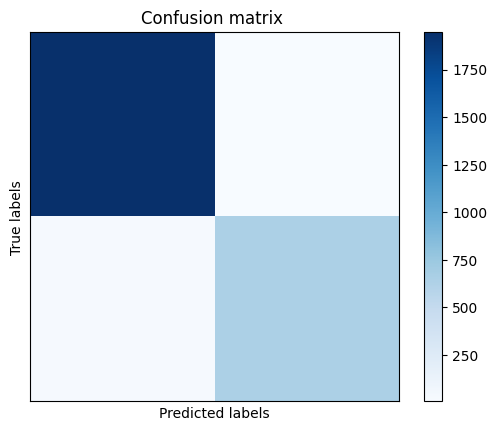

In [ ]:
#plotting the confusion matrix for testing data

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

AUC score:  0.9905994497616926
Accuracy:  0.9897142857142858
F1 score:  0.9796533534287868
Precision score:  0.9672619047619048
Recall score:  0.9923664122137404


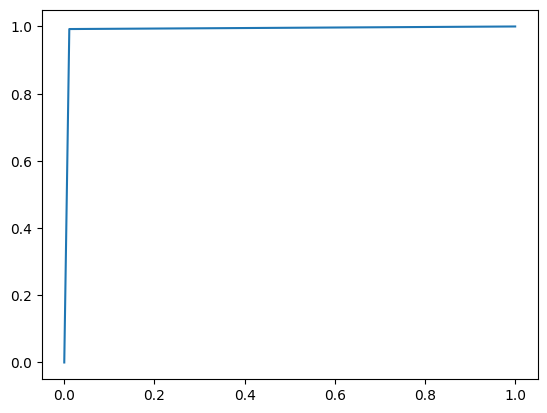

In [ ]:
#Computing the 5 evaluation metrics and printing

acc = accuracy_score(targets2, preds2)

fpr, tpr, _ = roc_curve(targets2, preds2)

area = roc_auc_score(targets2, preds2)
print("AUC score: ", area)

print("Accuracy: ", acc)

f1 = f1_score(targets2, preds2)
print("F1 score: ", f1)

pre = precision_score(targets2, preds2)
print("Precision score: ", pre)

recall = recall_score(targets2, preds2)
print("Recall score: ", recall)

plt.plot(fpr, tpr)

Text(0, 0.5, 'loss')

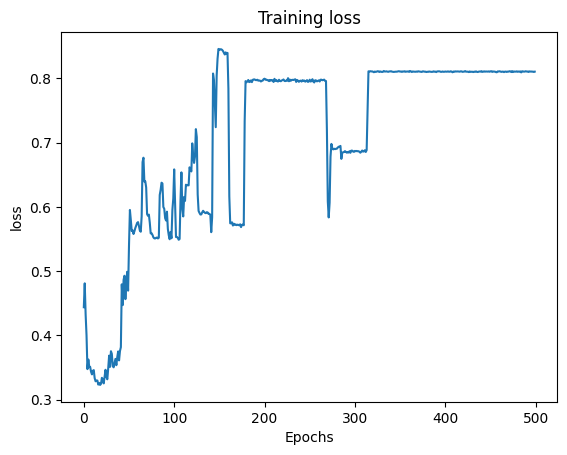

In [ ]:
#Plotting the training loss
train_loss_cpu = [loss.item() for loss in train_loss]

plt.plot(train_loss_cpu)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

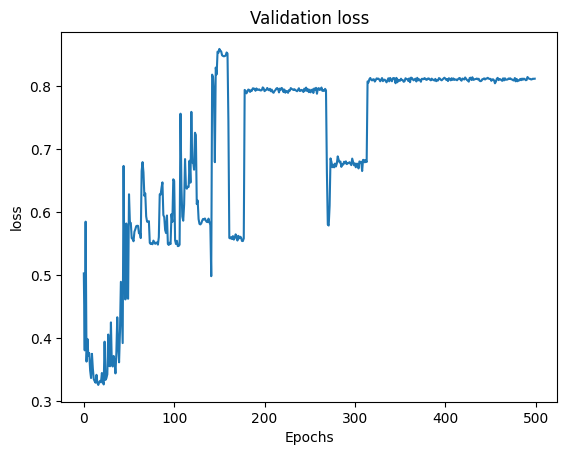

In [ ]:
#Plotting the validation loss
val_loss_cpu = [loss.item() for loss in valid_loss]

plt.plot(val_loss_cpu)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")